In [4]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/archive/

# Učitavanje podataka
import pandas as pd
df = pd.read_csv("Student Performance new.csv")

# Prikaz prvih 5 redaka
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/archive


,Unnamed: 0,race/ethnicity,parental level of education,lunch,test preparation course,math percentage,reading score percentage,writing score percentage,sex
0,0,group B,bachelor's degree,standard,none,0.72,0.72,0.74,F
1,1,group C,some college,standard,completed,0.69,0.90,0.88,F
2,2,group B,master's degree,standard,none,0.90,0.95,0.93,F
3,3,group A,associate's degree,free/reduced,none,0.47,0.57,0.44,M
4,4,group C,some college,standard,none,0.76,0.78,0.75,M


In [5]:
# Osnovne informacije o podacima
df.info()
df.describe()

# Provjera nedostajućih vrijednosti
print(df.isnull().sum())

# Uklanjanje nepotrebne kolone
df.drop(columns=["Unnamed: 0"], inplace=True)

# Dodavanje total i average rezultata
df["total_score"] = (df["math percentage"] + df["reading score percentage"] + df["writing score percentage"]) * 100
df["average_score"] = df["total_score"] / 3

# Binarna kolona 'passed' - 1 ako je prosjek >= 70
df["passed"] = (df["average_score"] >= 70).astype(int)

# Koliko učenika je prošlo (postotak)
print(df["passed"].value_counts(normalize=True) * 100)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Unnamed: 0                   1000 non-null   int64  
 1   race/ethnicity               1000 non-null   object 
 2   parental level of education  1000 non-null   object 
 3   lunch                        1000 non-null   object 
 4   test preparation course      1000 non-null   object 
 5   math percentage              1000 non-null   float64
 6   reading score percentage     1000 non-null   float64
 7   writing score percentage     1000 non-null   float64
 8   sex                          1000 non-null   object 
dtypes: float64(3), int64(1), object(5)
memory usage: 70.4+ KB
Unnamed: 0                     0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math percentage              

1000 redaka, 9 stupaca
54.7 % učenika nije prošlo, 45.3% je prošlo

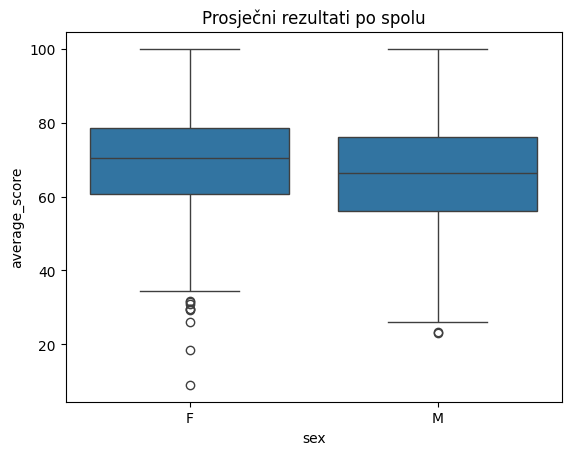

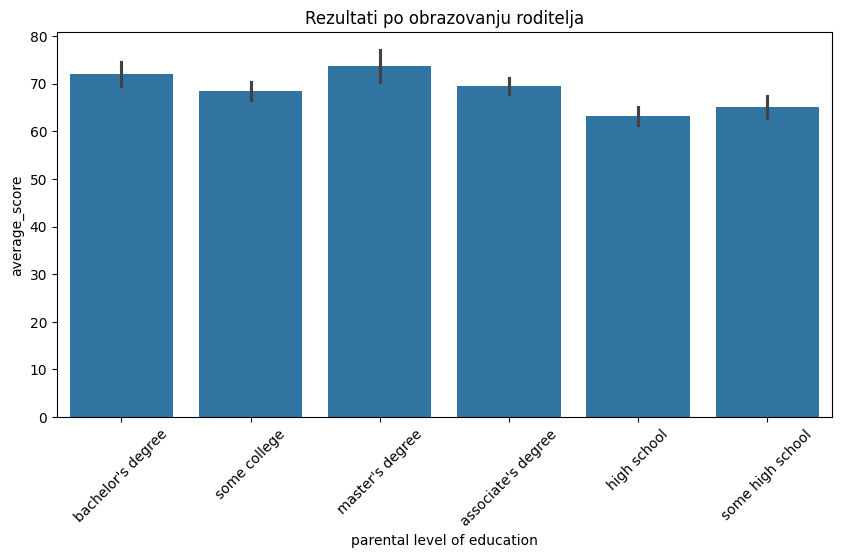

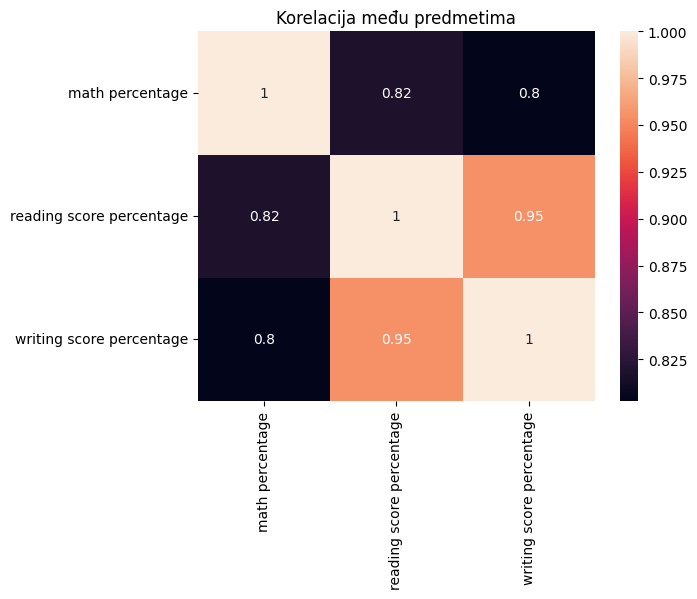

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Boxplot - razlike između spolova
sns.boxplot(x="sex", y="average_score", data=df)
plt.title("Prosječni rezultati po spolu")
plt.savefig("/content/drive/MyDrive/archive/boxplot_spol_vs_rezultati.png")
plt.show()

# 2. Barplot - razine obrazovanja roditelja
plt.figure(figsize=(10,5))
sns.barplot(x="parental level of education", y="average_score", data=df)
plt.xticks(rotation=45)
plt.title("Rezultati po obrazovanju roditelja")
plt.savefig("/content/drive/MyDrive/archive/barplot_obrazovanje_roditelja.png")
plt.show()

# 3. Korelacija između predmeta
sns.heatmap(df[["math percentage", "reading score percentage", "writing score percentage"]].corr(), annot=True)
plt.title("Korelacija među predmetima")
plt.savefig("/content/drive/MyDrive/archive/heatmap_korelacija.png")
plt.show()


In [7]:
# Priprema podataka
from sklearn.preprocessing import LabelEncoder

df_encoded = df.copy()
for col in ["sex", "race/ethnicity", "parental level of education", "lunch", "test preparation course"]:
    df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col])

X = df_encoded.drop(columns=["total_score", "average_score", "passed"])
y = df_encoded["passed"]


LabelEncoder pretvara tekstualne kategorije u numeričke vrijednosti (npr. 'male' → 1, 'female' → 0). Ovo je često neophodno za modele koji ne prihvaćaju stringove. X sadrži sve značajke osim rezultata i ciljne varijable, spremno za model. y je cilj — oznaka prolaska.

In [8]:
# ML Model – Random Forest
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Podjela na trening i test skup
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Treniranje modela
model_rf = RandomForestClassifier()
model_rf.fit(X_train, y_train)

# Predikcija i evaluacija
y_pred_rf = model_rf.predict(X_test)

print("Random Forest - Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))


Random Forest - Confusion Matrix:
[[107   3]
 [  3  87]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       110
           1       0.97      0.97      0.97        90

    accuracy                           0.97       200
   macro avg       0.97      0.97      0.97       200
weighted avg       0.97      0.97      0.97       200



106 je broj točno klasificiranih negativnih primjera (prošli nisu).
4 su negativni koje je model krivo klasificirao kao pozitivne (lažno pozitivni).
2 su pozitivni koje je model krivo klasificirao kao negativne (lažno negativni).
88 je broj točno klasificiranih pozitivnih primjera (prošli su).
To znači da model ima vrlo malo pogrešaka, što je jako dobar rezultat.
Precision -> Od svih označenih kao klasa, koliko je točno.
Recall	0.96	0.98	Od svih stvarno u toj klasi, koliko ih je model pronašao?
F1-scoreall -> Od svih stvarno u toj klasi, koliko ih je model pronašao.
Support -> 	Broj stvarnih uzoraka po klasi



In [ ]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Normalizacija ulaza
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Definicija DL modela
model_dl = Sequential([
    Dense(16, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Kompilacija modela
model_dl.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping da spriječimo overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Treniranje modela
history = model_dl.fit(
    X_train_scaled, y_train,
    epochs=20,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# Evaluacija na test skupu
loss, accuracy = model_dl.evaluate(X_test_scaled, y_test)
print(f"Deep Learning - Test Accuracy: {accuracy * 100:.2f}%")


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.4327 - loss: 0.7623 - val_accuracy: 0.6125 - val_loss: 0.6800
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5767 - loss: 0.6796 - val_accuracy: 0.7375 - val_loss: 0.6117
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7490 - loss: 0.6006 - val_accuracy: 0.8250 - val_loss: 0.5442
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8329 - loss: 0.5360 - val_accuracy: 0.8875 - val_loss: 0.4805
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8762 - loss: 0.4637 - val_accuracy: 0.9187 - val_loss: 0.4169
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9096 - loss: 0.3950 - val_accuracy: 0.9375 - val_loss: 0.3607
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9293 - loss: 0.3381 - val_accuracy: 0.9625 - val_loss: 0.3124
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9378 - loss: 0.2955 - val_accuracy: 0.9750 - val_loss: 0.2705
Ep

In [10]:
#Usporedba modela
from sklearn.metrics import accuracy_score

# DL predikcije
y_pred_dl = model_dl.predict(X_test_scaled).flatten()
y_pred_dl = (y_pred_dl >= 0.5).astype(int)

# Točna usporedba
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Deep Learning Accuracy:", accuracy_score(y_test, y_pred_dl))


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Random Forest Accuracy: 0.97
Deep Learning Accuracy: 0.98


In [12]:
from google.colab import files

# Preuzmi Random Forest model
files.download('model_rf.pkl')

# Preuzmi scaler
files.download('scaler.pkl')

# Preuzmi deep learning model
files.download('model_dl.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>